# Setting

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import Model, load_model, Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import gc


In [4]:
import numpy as np

# Specify the filename of saved .npz file
filename = "/kaggle/input/dfdc-training-data-gs/training_data_CLL.npz"

# Load the data from the .npz file using np.load
data = np.load(filename)

# Access the individual data arrays from the loaded data object
Video_train = data['Video_train']
Video_test = data['Video_test']
Audio_train = data['Audio_train']
Audio_test = data['Audio_test']
y_train = data['y_train']
y_test = data['y_test']

In [5]:
max_sequence_video = 19 #max(len(video) for video in final_video_data)
max_sequence_audio = 25
video_shape = (max_sequence_video, 50 , 100, 1)
audio_shape = (max_sequence_audio , 128)


# Model Building

In [6]:
def CNN_LSTM_model(input_shape, drop_out):
    # Model Architecture
    video_input = Input(shape=input_shape)

    # Model Architecture
    x = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'))(video_input)
    x = TimeDistributed(MaxPooling2D((4, 4)))(x)
    x = TimeDistributed(Dropout(drop_out))(x)

    x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Dropout(drop_out))(x)

    x = TimeDistributed(Conv2D(48, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Dropout(drop_out))(x)

    x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Flatten())(x)
    
    x = LSTM(128, return_sequences=True)(x)
    video_features = LSTM(64)(x)

    # Create the model
    video_model = Model(inputs=video_input, outputs=video_features)

    return video_model

In [7]:
def LSTM_model(input_shape, drop_out):
    audio_input = Input(shape=input_shape)
    
    # Add Masking layer to handle variable-length sequences
    x = Masking(mask_value=0.0)(audio_input)
    
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(drop_out)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(drop_out)(x)
    x = LSTM(64, return_sequences=False)(x)
    
    # Create the model
    audio_model = Model(inputs=audio_input, outputs=x)

    return audio_model

In [8]:
def cross_attention_block(video_features, audio_features):
    # reshape to add one dimension which is required by keras attention()
    video_features = Reshape((64,1))(video_features)
    audio_features = Reshape((64,1))(audio_features)
    
    # Compute attention score
    video_attention = Attention()([audio_features, video_features])
    audio_attention = Attention()([video_features, audio_features])
    
    # element-wise add tensors to combine the score and feature
    video_combined = Add()([video_features, video_attention])
    audio_combined = Add()([audio_features, audio_attention])
    
    return video_combined, audio_combined

In [9]:
def combined_model(video_input_shape, audio_input_shape, drop_out):
    # Create the video and audio models
    video_model = CNN_LSTM_model(video_input_shape, drop_out)
    audio_model = LSTM_model(audio_input_shape, drop_out)

    # Get the inputs and outputs
    video_feature = video_model.input
    audio_feature = audio_model.input
        
    # Apply cross-attention to the video and audio features
    video_attention, audio_attention = cross_attention_block(video_model.output, audio_model.output)
    
    combined_features = Concatenate()([video_attention, audio_attention])
    
    # Fully connected layer
    x = Flatten()(combined_features)
    x = Dense(128, activation='relu')(x)
    x = Dropout(drop_out)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(drop_out)(x)
    x = Dense(32, activation='relu')(x)
    # Output layer
    output = Dense(1, activation='sigmoid')(x)

    # Create the combined model
    model = Model(inputs=[video_feature, audio_feature], outputs=output)
    return model

In [10]:
model = combined_model(video_shape, audio_shape, 0.2)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 19, 50,    │          0 │ -                 │
│ (InputLayer)        │ 100, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 19, 50,    │        160 │ input_layer[0][0] │
│ (TimeDistributed)   │ 100, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 19, 12,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 25, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 19, 12,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 25, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 19, 12,    │      4,640 │ time_distributed… │
│ (TimeDistributed)   │ 25, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 19, 6, 12, │          0 │ time_distributed… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 19, 6, 12, │          0 │ time_distributed… │
│ (TimeDistributed)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 19, 6, 12, │     13,872 │ time_distributed… │
│ (TimeDistributed)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 25, 128)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 19, 3, 6,  │          0 │ time_distributed… │
│ (TimeDistributed)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25, 128)   │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 19, 3, 6,  │          0 │ time_distributed… │
│ (TimeDistributed)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 25, 128)   │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 25)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 19, 3, 6,  │     27,712 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 25, 128)   │    131,584 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 19, 1, 3,  │          0 │ time_distributed… │
│ (TimeDistributed)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 501,041 (1.91 MB)

 Trainable params: 501,041 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

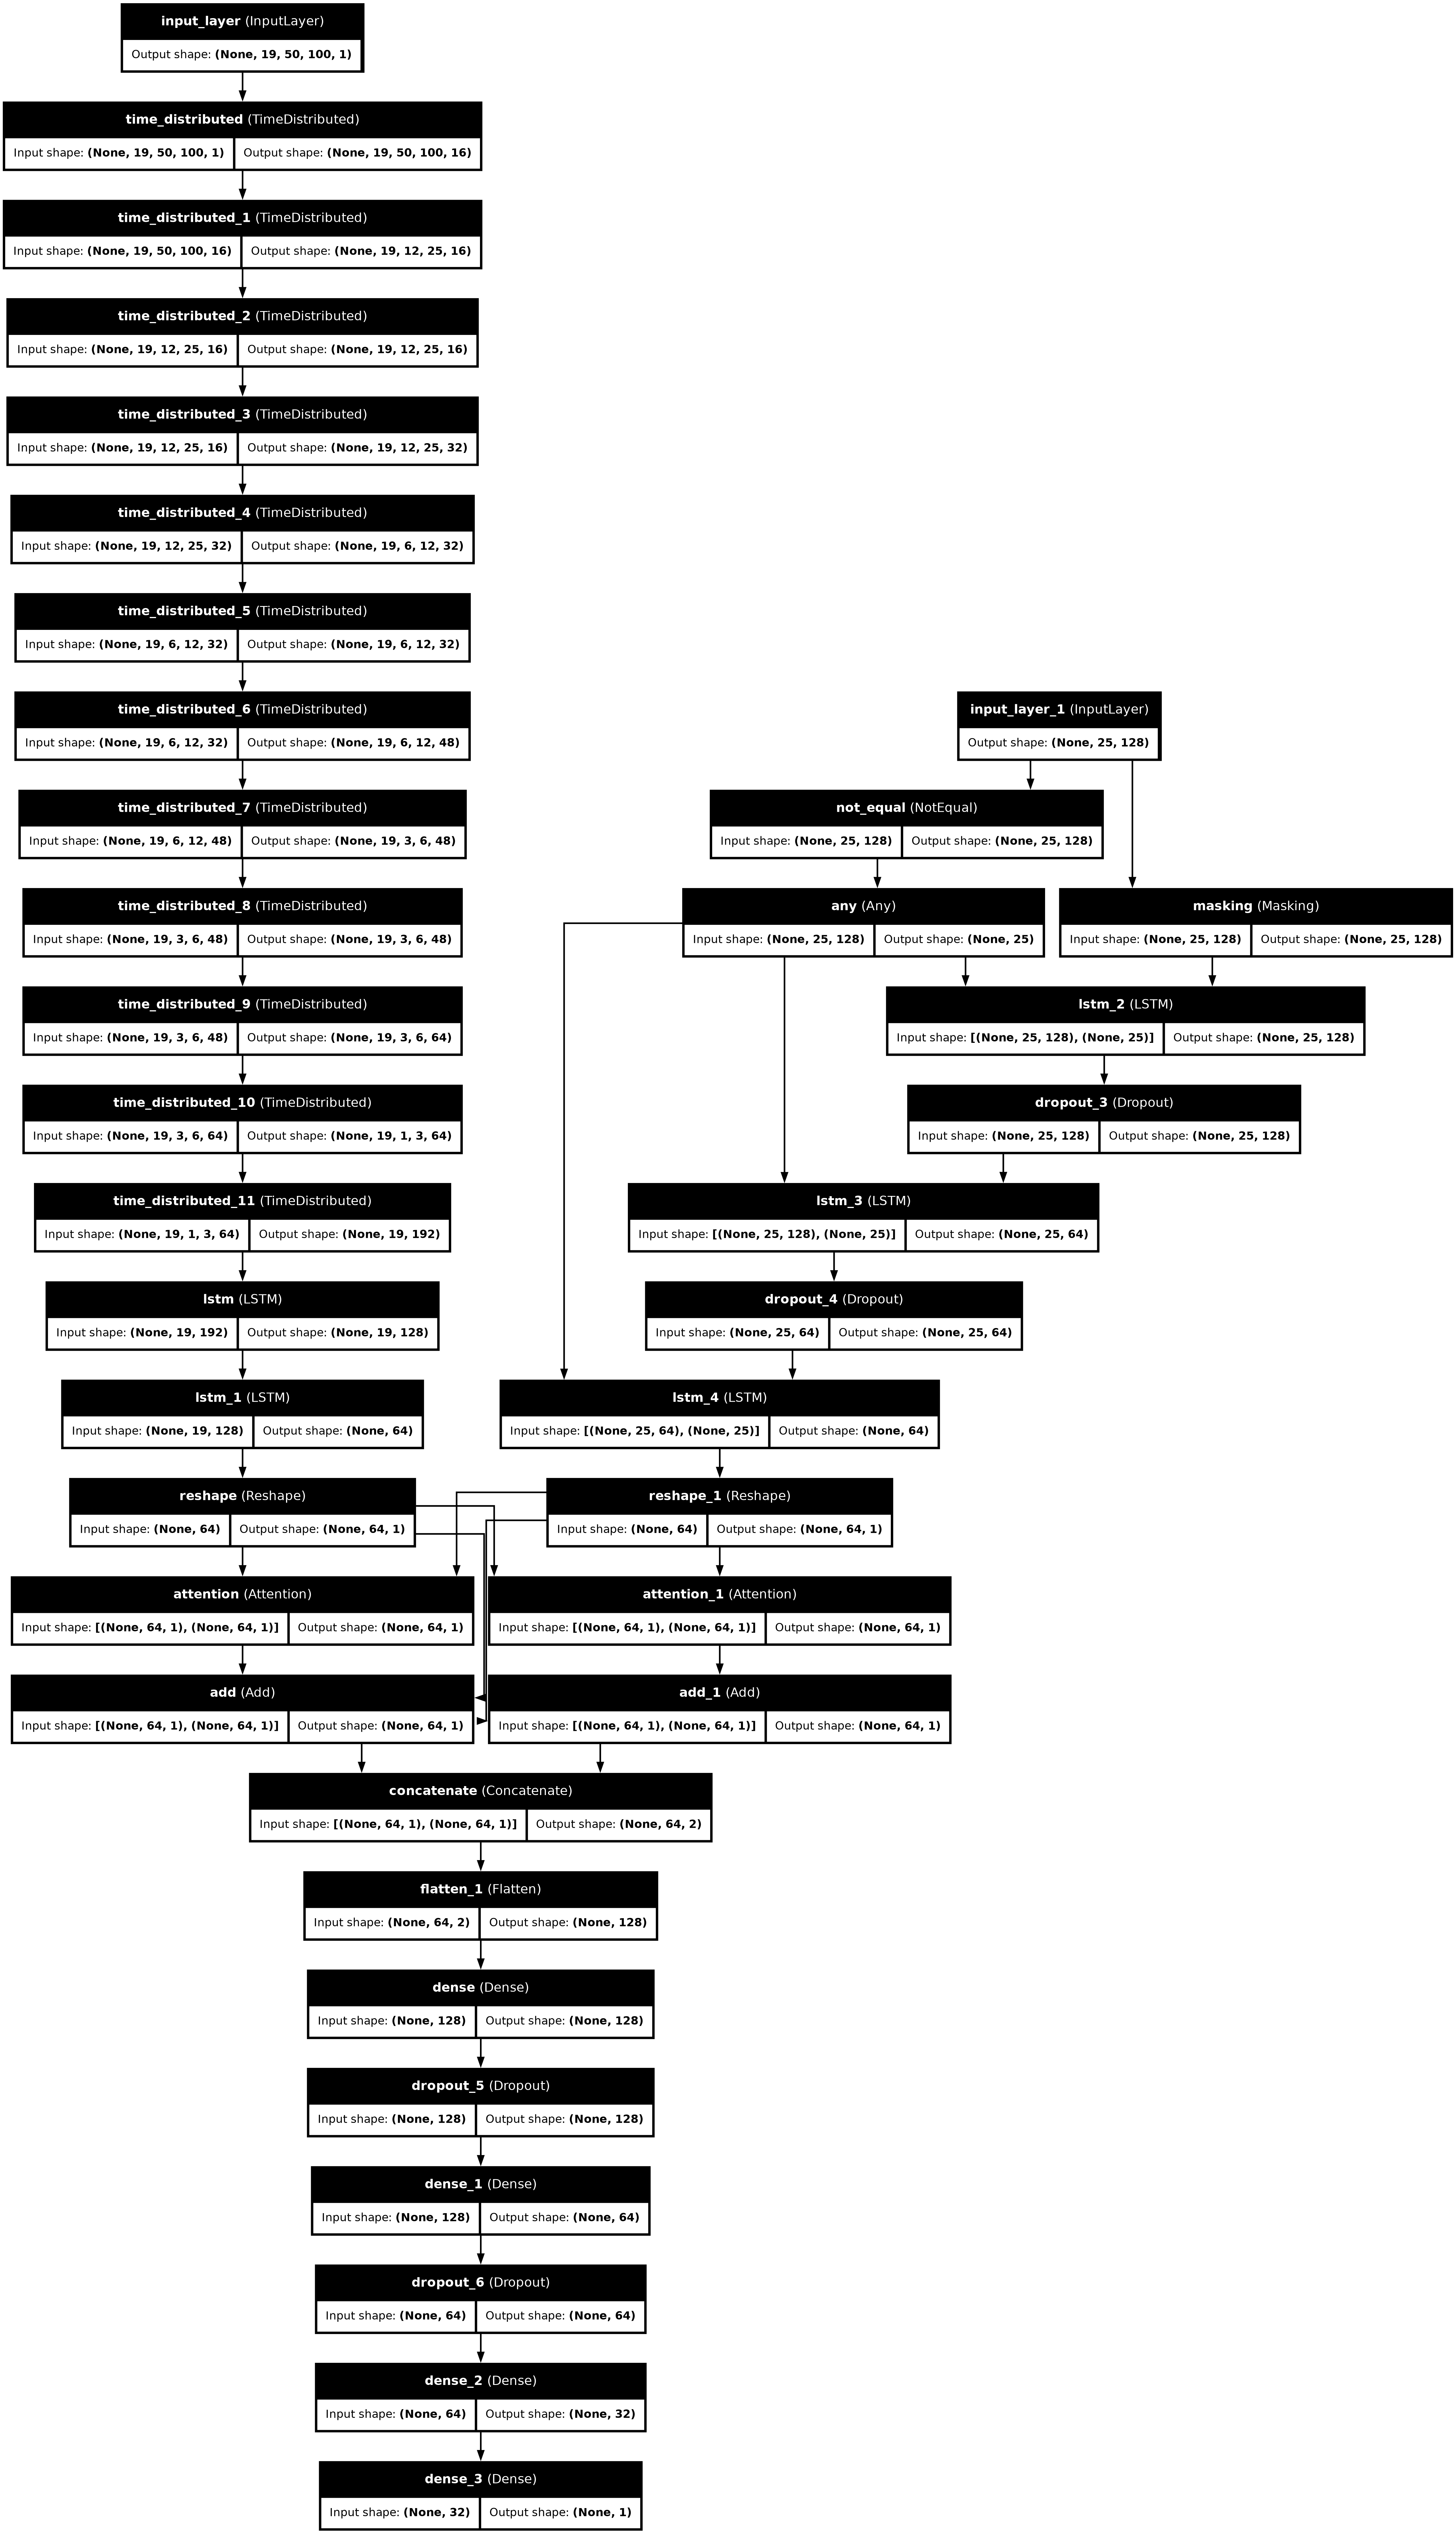

In [11]:
plot_model(model, show_shapes = True, show_layer_names = True)

## Model training

In [ ]:
# Create Early Stopping Callback.
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss = 'binary_crossentropy', optimizer = "adam" , metrics = ["accuracy"])
    
# Start training the model.
model_training = model.fit(x =[Video_train, Audio_train], y = y_train,
                                    epochs = 40, batch_size = 32 ,validation_data=([Video_test, Audio_test], y_test),
                                    shuffle = True,
                                    callbacks = [early_stopping])

Epoch 1/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 72s 140ms/step - accuracy: 0.5432 - loss: 0.6872 - val_accuracy: 0.5971 - val_loss: 0.6592
Epoch 2/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 124ms/step - accuracy: 0.6427 - loss: 0.6341 - val_accuracy: 0.6414 - val_loss: 0.6660
Epoch 3/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.6882 - loss: 0.5889 - val_accuracy: 0.7493 - val_loss: 0.5194
Epoch 4/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 124ms/step - accuracy: 0.7374 - loss: 0.5167 - val_accuracy: 0.7599 - val_loss: 0.4675
Epoch 5/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7839 - loss: 0.4724 - val_accuracy: 0.8166 - val_loss: 0.4081
Epoch 6/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8139 - loss: 0.4151 - val_accuracy: 0.8387 - val_loss: 0.3670
Epoch 7/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 124ms/step - accuracy: 0.8308 - loss: 0.3763 - val_accuracy: 0.8426 - val_loss: 0.3565
Epoch 8/40
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.8563 - loss: 0

## Plotting accuracy and loss

In [12]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

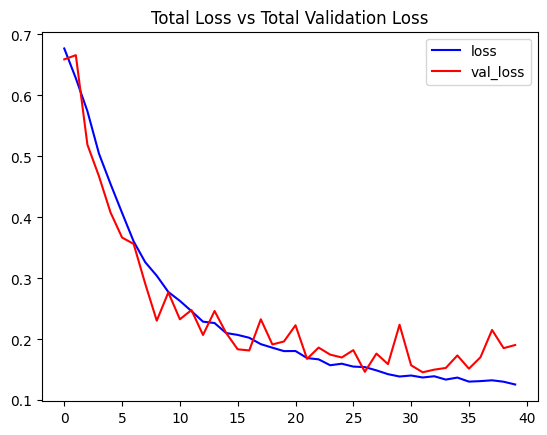

In [13]:
# Visualize the training and validation loss metrices.
plot_metric(model_training, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

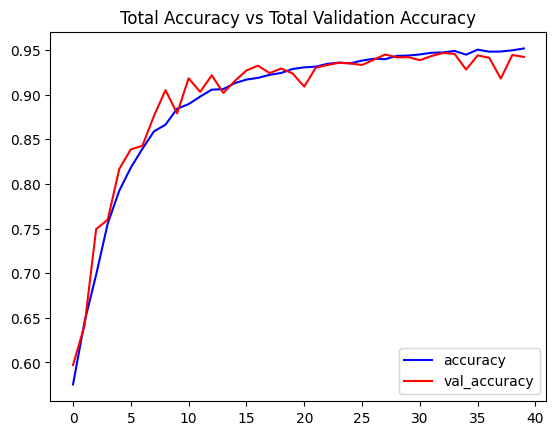

In [14]:
# Visualize the training and validation accuracy metrices.
plot_metric(model_training, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

## Model Evaluation

In [15]:
# Evaluate the trained model.
model_evaluation = model.evaluate([Video_test, Audio_test], y_test)

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9435 - loss: 0.1398


## Hyperparameter tunning

In [11]:
pip install --upgrade keras-hypetune

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.0/966.0 kB 13.6 MB/s eta 0:00:0000:010:01
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.2.7
    Uninstalling hyperopt-0.2.7:
      Successfully uninstalled hyperopt-0.2.7
Note: you may need to restart the kernel to use updated packages.


In [1]:
from kerashypetune import KerasGridSearch, KerasGridSearchCV

param_grid = {
    'batch_size': [16, 32, 48],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'dropout_rate': [0.2, 0.35, 0.5],
    'epochs': [40]
}

def get_model(param):       
    # Define the model 
    model = combined_model(video_shape, audio_shape, param['dropout_rate'])
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=param['optimizer'], metrics=['accuracy'])
    
    return model

# Create Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

kgs = KerasGridSearch(get_model, param_grid, monitor='val_loss', greater_is_better=False)


kgs.search([Video_train,Audio_train], y_train, validation_data=([Video_test, Audio_test], y_test), callbacks=[early_stopping])


27 trials detected for ('batch_size', 'optimizer', 'dropout_rate', 'epochs')

***** (1/27) *****
Search({'batch_size': 16, 'optimizer': 'rmsprop', 'dropout_rate': 0.2, 'epochs': 40})
SCORE: 0.14698 at epoch 36

***** (2/27) *****
Search({'batch_size': 16, 'optimizer': 'rmsprop', 'dropout_rate': 0.35, 'epochs': 40})
SCORE: 0.18359 at epoch 37

***** (3/27) *****
Search({'batch_size': 16, 'optimizer': 'rmsprop', 'dropout_rate': 0.5, 'epochs': 40})
SCORE: 0.29644 at epoch 27

***** (4/27) *****
Search({'batch_size': 16, 'optimizer': 'sgd', 'dropout_rate': 0.2, 'epochs': 40})
SCORE: 0.38697 at epoch 40

***** (5/27) *****
Search({'batch_size': 16, 'optimizer': 'sgd', 'dropout_rate': 0.35, 'epochs': 40})
SCORE: 0.40509 at epoch 36

***** (6/27) *****
Search({'batch_size': 16, 'optimizer': 'sgd', 'dropout_rate': 0.5, 'epochs': 40})
SCORE: 0.44638 at epoch 40

***** (7/27) *****
Search({'batch_size': 16, 'optimizer': 'adam', 'dropout_rate': 0.2, 'epochs': 40})
SCORE: 0.44666 at epoch 38

***

In [4]:
kgs.best_score

0.13312


In [5]:
kgs.best_params


{'batch_size': 32, 
'optimizer': 'rmsprop', 
'dropout_rate': 0.2, 
'epochs': 40
'steps_per_epoch: 383'}



## Retrain model with best parameter

In [15]:
optimized_model = combined_model(video_shape, audio_shape, 0.2)

# Create Early Stopping Callback.
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
optimized_model.compile(loss = 'binary_crossentropy', optimizer = "rmsprop" , metrics = ["accuracy"])
    
# Start training the model.
optimized_model_training = optimized_model.fit(x =[Video_train, Audio_train], y = y_train,
                                    epochs = 70, batch_size = 32 ,validation_data=([Video_test, Audio_test], y_test),
                                    shuffle = True,
                                    callbacks = [early_stopping])

Epoch 1/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 67s 137ms/step - accuracy: 0.5625 - loss: 0.6793 - val_accuracy: 0.6215 - val_loss: 0.6389
Epoch 2/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.6443 - loss: 0.6323 - val_accuracy: 0.6857 - val_loss: 0.5724
Epoch 3/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.6737 - loss: 0.6026 - val_accuracy: 0.6840 - val_loss: 0.5879
Epoch 4/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.7236 - loss: 0.5364 - val_accuracy: 0.7310 - val_loss: 0.5140
Epoch 5/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - accuracy: 0.7697 - loss: 0.4822 - val_accuracy: 0.8051 - val_loss: 0.4406
Epoch 6/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8056 - loss: 0.4298 - val_accuracy: 0.8215 - val_loss: 0.3968
Epoch 7/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8214 - loss: 0.3958 - val_accuracy: 0.8539 - val_loss: 0.3727
Epoch 8/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 123ms/step - accuracy: 0.8515 - loss: 0

## Model Evaluation

In [24]:
# Evaluate the optimized model.
model_evaluation = optimized_model.evaluate([Video_test, Audio_test], y_test)

128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9544 - loss: 0.1283


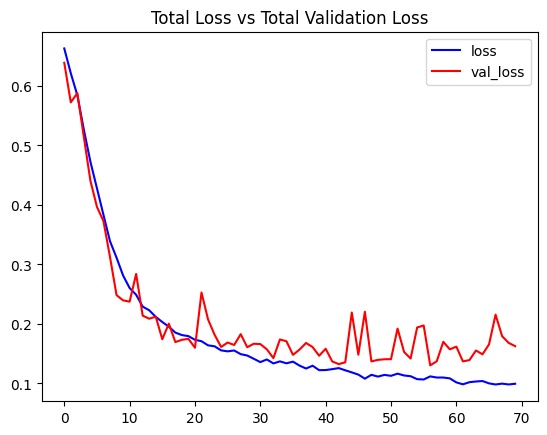

In [25]:
# Visualize the training and validation loss metrices.
plot_metric(optimized_model_training, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

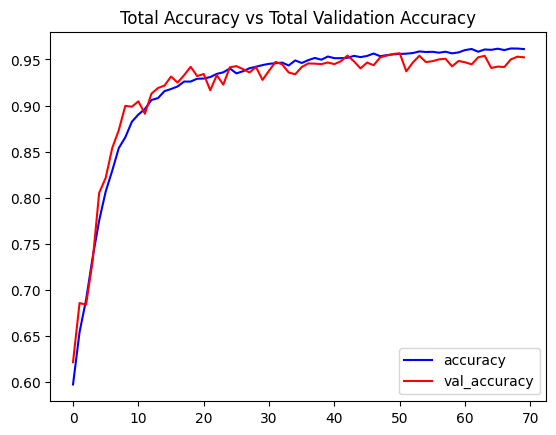

In [26]:
# Visualize the training and validation accuracy metrices.
plot_metric(optimized_model_training, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [27]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation

model_file_name = f"Op_CLC_CrossAttention__Loss_{model_evaluation_loss}_Acc_{model_evaluation_accuracy}.h5"

optimized_model.save(f"/kaggle/working/{model_file_name}")

In [28]:
predictions = optimized_model.predict([Video_test, Audio_test])

# Convert probabilities to class labels (0 for deepfake, 1 for real)
predicted_labels = (predictions > 0.5).astype(int)

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [29]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_test, predicted_labels, target_names=['Fake', 'Real'])
print(report)

              precision    recall  f1-score   support

        Fake       0.93      0.96      0.95      1906
        Real       0.97      0.94      0.95      2179

    accuracy                           0.95      4085
   macro avg       0.95      0.95      0.95      4085
weighted avg       0.95      0.95      0.95      4085



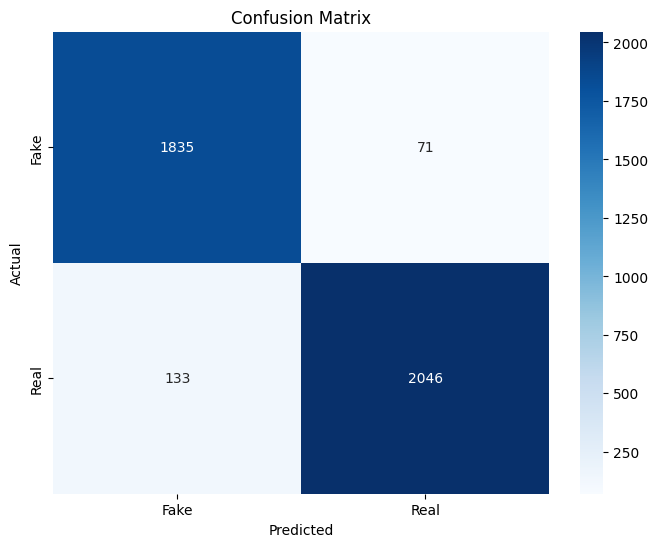

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

AUC Score: 0.9892235432466832


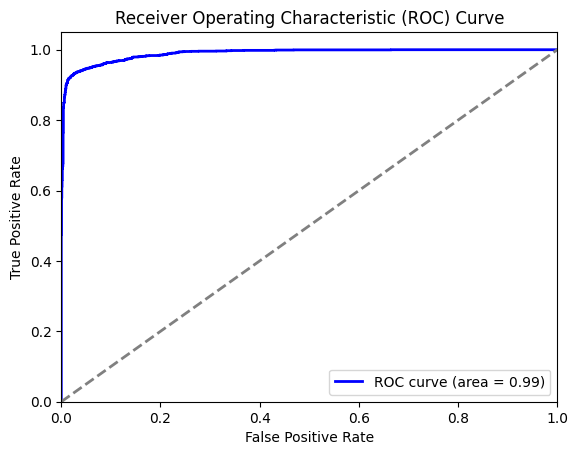

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, predictions)
print(f"AUC Score: {auc_score}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Cross validation

In [9]:
# Load data 
# Specify the filename of saved .npz file
filename = "/kaggle/input/unsplited-training-data/unsplited_data_CLL.npz"

# Load the data from the .npz file using np.load
data = np.load(filename)

# Access the individual data arrays from the loaded data object
video_data = data['final_video_data']
audio_data = data['final_audio_data']
labels = data['encoded_labels']


In [10]:
from sklearn.model_selection import KFold

# K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=50)

fold_no = 1

fold_scores = []


for train_index, test_index in kfold.split(labels):
    print(f'Training on fold {fold_no}...')
    
    video_train, video_test = video_data[train_index], video_data[test_index]
    audio_train, audio_test = audio_data[train_index], audio_data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    model = combined_model(video_shape, audio_shape, 0.2)

    # Create Early Stopping Callback.
    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

    # Compile the model and specify loss function, optimizer and metrics to the model.
    model.compile(loss = 'binary_crossentropy', optimizer = "rmsprop" , metrics = ["accuracy"])

    # Start training the model.
    model_training = model.fit(x =[video_train, audio_train], y = y_train,
                                        epochs = 70, batch_size = 32 ,validation_data=([video_test, audio_test], y_test),
                                        shuffle = True,
                                        callbacks = [early_stopping])
    
    # Evaluation
    model_evaluation = model.evaluate([video_test, audio_test], y_test)
    
    performance = f'Fold {fold_no}: Accuracy - {model_evaluation[1]:.4f} | Loss - {model_evaluation[0]:.4f}'
    print(performance)
    
    fold_scores.append(performance)
    fold_no += 1

Training on fold 1...
Epoch 1/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 73s 135ms/step - accuracy: 0.5401 - loss: 0.6847 - val_accuracy: 0.6111 - val_loss: 0.6516
Epoch 2/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 49s 121ms/step - accuracy: 0.6394 - loss: 0.6348 - val_accuracy: 0.6995 - val_loss: 0.5988
Epoch 3/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 49s 120ms/step - accuracy: 0.7163 - loss: 0.5538 - val_accuracy: 0.7858 - val_loss: 0.4834
Epoch 4/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 49s 119ms/step - accuracy: 0.7553 - loss: 0.5044 - val_accuracy: 0.8115 - val_loss: 0.4305
Epoch 5/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - accuracy: 0.7979 - loss: 0.4412 - val_accuracy: 0.8014 - val_loss: 0.4422
Epoch 6/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 49s 119ms/step - accuracy: 0.8217 - loss: 0.3972 - val_accuracy: 0.8384 - val_loss: 0.3838
Epoch 7/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 49s 119ms/step - accuracy: 0.8378 - loss: 0.3663 - val_accuracy: 0.8788 - val_loss: 0.3163
Epoch 8/70
409/409 ━━━━━━━━━━━━━━━━━━━━ 49s 119ms/step - accu

In [13]:
for score in fold_scores:
    print(score)

Fold 1: Accuracy - 0.9596 | Loss - 0.1174
Fold 2: Accuracy - 0.9492 | Loss - 0.1487
Fold 3: Accuracy - 0.9569 | Loss - 0.1198
Fold 4: Accuracy - 0.9513 | Loss - 0.1310
Fold 5: Accuracy - 0.9489 | Loss - 0.1373
